# 重新实现之前的线性热模型
应该只需要读取第一次实验的数据，这里主要想规范一下之前的写法

In [1]:
import pandas as pd
import numpy as np
import os
from keys import *
import math

from tqdm import tqdm
from loader import Loader
from thermal_model.data import *
from thermal_model.configs import *
from thermal_model.figure_plotter import *
from utils_thermal_model_raw_process import *
import matplotlib.pyplot as plt
from plotter import Plotter
import seaborn as sns
from sklearn.linear_model import LinearRegression,Lars
from sklearn.ensemble import RandomForestRegressor
from thermal_model.thermal_model import fit_random_forest, model_estimator,fit_LARS
import pickle
import math
from thermal_model.electrolyzer import Electrolyzer
from thermal_model.original_thermal_model_and_plotter_0117 import cooling_Power_Qlye


# 读取数据并且缓存成单独pickle

In [ ]:
df_thermal_model_data_raw = ThermalModelData().load()

# 生成线性模型的输入项

In [ ]:
df_thermal_model_data_input = generate_model_input(df_thermal_model_data_raw)

In [ ]:
df_thermal_model_data_input.columns

# 生成模型（应该使用线性模型）

In [ ]:
model_random_forest,model_input,model_target = fit_random_forest(df_thermal_model_data_input,6)

In [ ]:
( model_predict, error) = model_estimator(
    model_random_forest,model_input,model_target
)

In [ ]:
Thermal_model_regression_scatter(
    model_target = model_target,
    model_predict = model_predict,
    title_model="随机森林",
).save()

In [ ]:
Thermal_model_regression_error_histplot(
    model_target=model_target,
    error=error,
    title_model="随机森林"
).save()

In [ ]:
Thermal_model_regression_cumulative_error_plot(
    model_target=model_target,
    model_predict=model_predict
).save()

In [ ]:
model_lars,model_input,model_target = fit_LARS(df_thermal_model_data_input)

In [ ]:
( model_predict, error) = model_estimator(
    model_lars,model_input,model_target
)

In [ ]:
Thermal_model_regression_scatter(
    model_target = model_target,
    model_predict = model_predict,
    title_model="LARS",
).save()

In [ ]:
Thermal_model_regression_error_histplot(
    model_target=model_target,
    error=error,
    title_model="LARS"
).save()

In [ ]:
Thermal_model_regression_cumulative_error_plot(
    model_target=model_target,
    model_predict=model_predict,
    title_model='LARS'
).save()

# 测试模型功能

In [2]:
class Model_cooling_power_requirement(QuadroPlotter):
    def __init__(
        self, 
        label="Thermal model", 
        title="不同碱液流量下的电解槽冷却功率需求", 
        num_subplot=4, 
        title_plot=False
    ) -> None:
        super().__init__(label, title, num_subplot, title_plot)
        self.electrolyzer = Electrolyzer()

    def plot_1(self):
        #不同碱液入口温度下电解槽出口温度

        lye_temperature_range = range(
            OperatingRange.Contour.Lye_temperature.left,
            OperatingRange.Contour.Lye_temperature.right,
            OperatingRange.Contour.Lye_temperature.step
        )
        current_range = range(
            OperatingRange.Contour.Current.left,
            OperatingRange.Contour.Current.right,
            OperatingRange.Contour.Current.step
        )
        ambient_temperature = OperatingCondition.Default.ambient_temperature
        lye_flow = OperatingCondition.Default.lye_flow
        cooling_power_matrix = np.ones(
            (
                len(lye_temperature_range),
                len(current_range)
            )
        ) # 出口温度
        for i in range(len(current_range)):
            for j in range(len(lye_temperature_range)):
                temperature_thermal_balance_cur  = (
                    self.electrolyzer.temperature_thermal_balance_current(
                        ambient_temperature=ambient_temperature,
                        lye_flow=lye_flow,
                        lye_temperature=lye_temperature_range[j],
                        current = current_range[i]
                    )
                )
                cooling_power_matrix[j,i] = self.electrolyzer.cooling_power_requirement(
                    temperature=temperature_thermal_balance_cur,
                    lye_temperature=lye_temperature_range[j],
                    lye_flow=lye_flow,
                )

                if (
                    lye_temperature_range[j] == OperatingCondition.Rated.lye_temperature
                ) and (
                    current_range[i]==OperatingCondition.Rated.current
                ):
                    cooling_power_default = cooling_power_matrix[j,i]
                if (
                    lye_temperature_range[j] == OperatingCondition.Optimal.lye_temperature
                ) and (
                    current_range[i]==OperatingCondition.Optimal.current
                ):
                    cooling_power_optimal = cooling_power_matrix[j,i]
                    
        self.plot_contour_map_with_2_points(
            matrix= cooling_power_matrix,
            x_range=np.array(current_range) ,
            y_range=lye_temperature_range,
            value_default=cooling_power_default,
            value_optimal=cooling_power_optimal,
            unit='kW'
        )
    
    def plot_2(self):
        # 这里画两条线，一条是冷却功率得绝对值，在不同碱液流量下的情况
        # 还有一条线是冷却功率需求占总功率得比例
        ambient_temperature_range = range(
            OperatingRange.Contour.Ambient_temperature.left,
            OperatingRange.Contour.Ambient_temperature.right,
            OperatingRange.Contour.Ambient_temperature.step
            )
        current = OperatingCondition.Rated.current
        lye_temperature = OperatingCondition.Rated.lye_temperature
        lye_flow_range = np.arange(
            OperatingRange.Contour.Lye_flow.left,
            OperatingRange.Contour.Lye_flow.right,
            OperatingRange.Contour.Lye_flow.step
            )
        for lye_flow in lye_flow_range:
            cooling_power_list = []
            cooling_power_ratio_list = []
            for ambient_temperature in ambient_temperature_range:
                temperature_cur = self.electrolyzer.temperature_thermal_balance_current(
                    ambient_temperature=ambient_temperature,
                    lye_flow= lye_flow,
                    lye_temperature = lye_temperature,
                    current=current
                )
                voltage_cur = self.electrolyzer.polar_current_lh(
                    current = current,
                    temperature=temperature_cur
                )
                cooling_power_cur = self.electrolyzer.cooling_power_requirement(
                    temperature=temperature_cur,
                    lye_temperature=lye_temperature,
                    lye_flow=lye_flow
                )



    def plot_3(self):
        1
    
    def plot_4(self):
        1

figure saved at Thermal model 不同碱液流量下的电解槽冷却功率需求


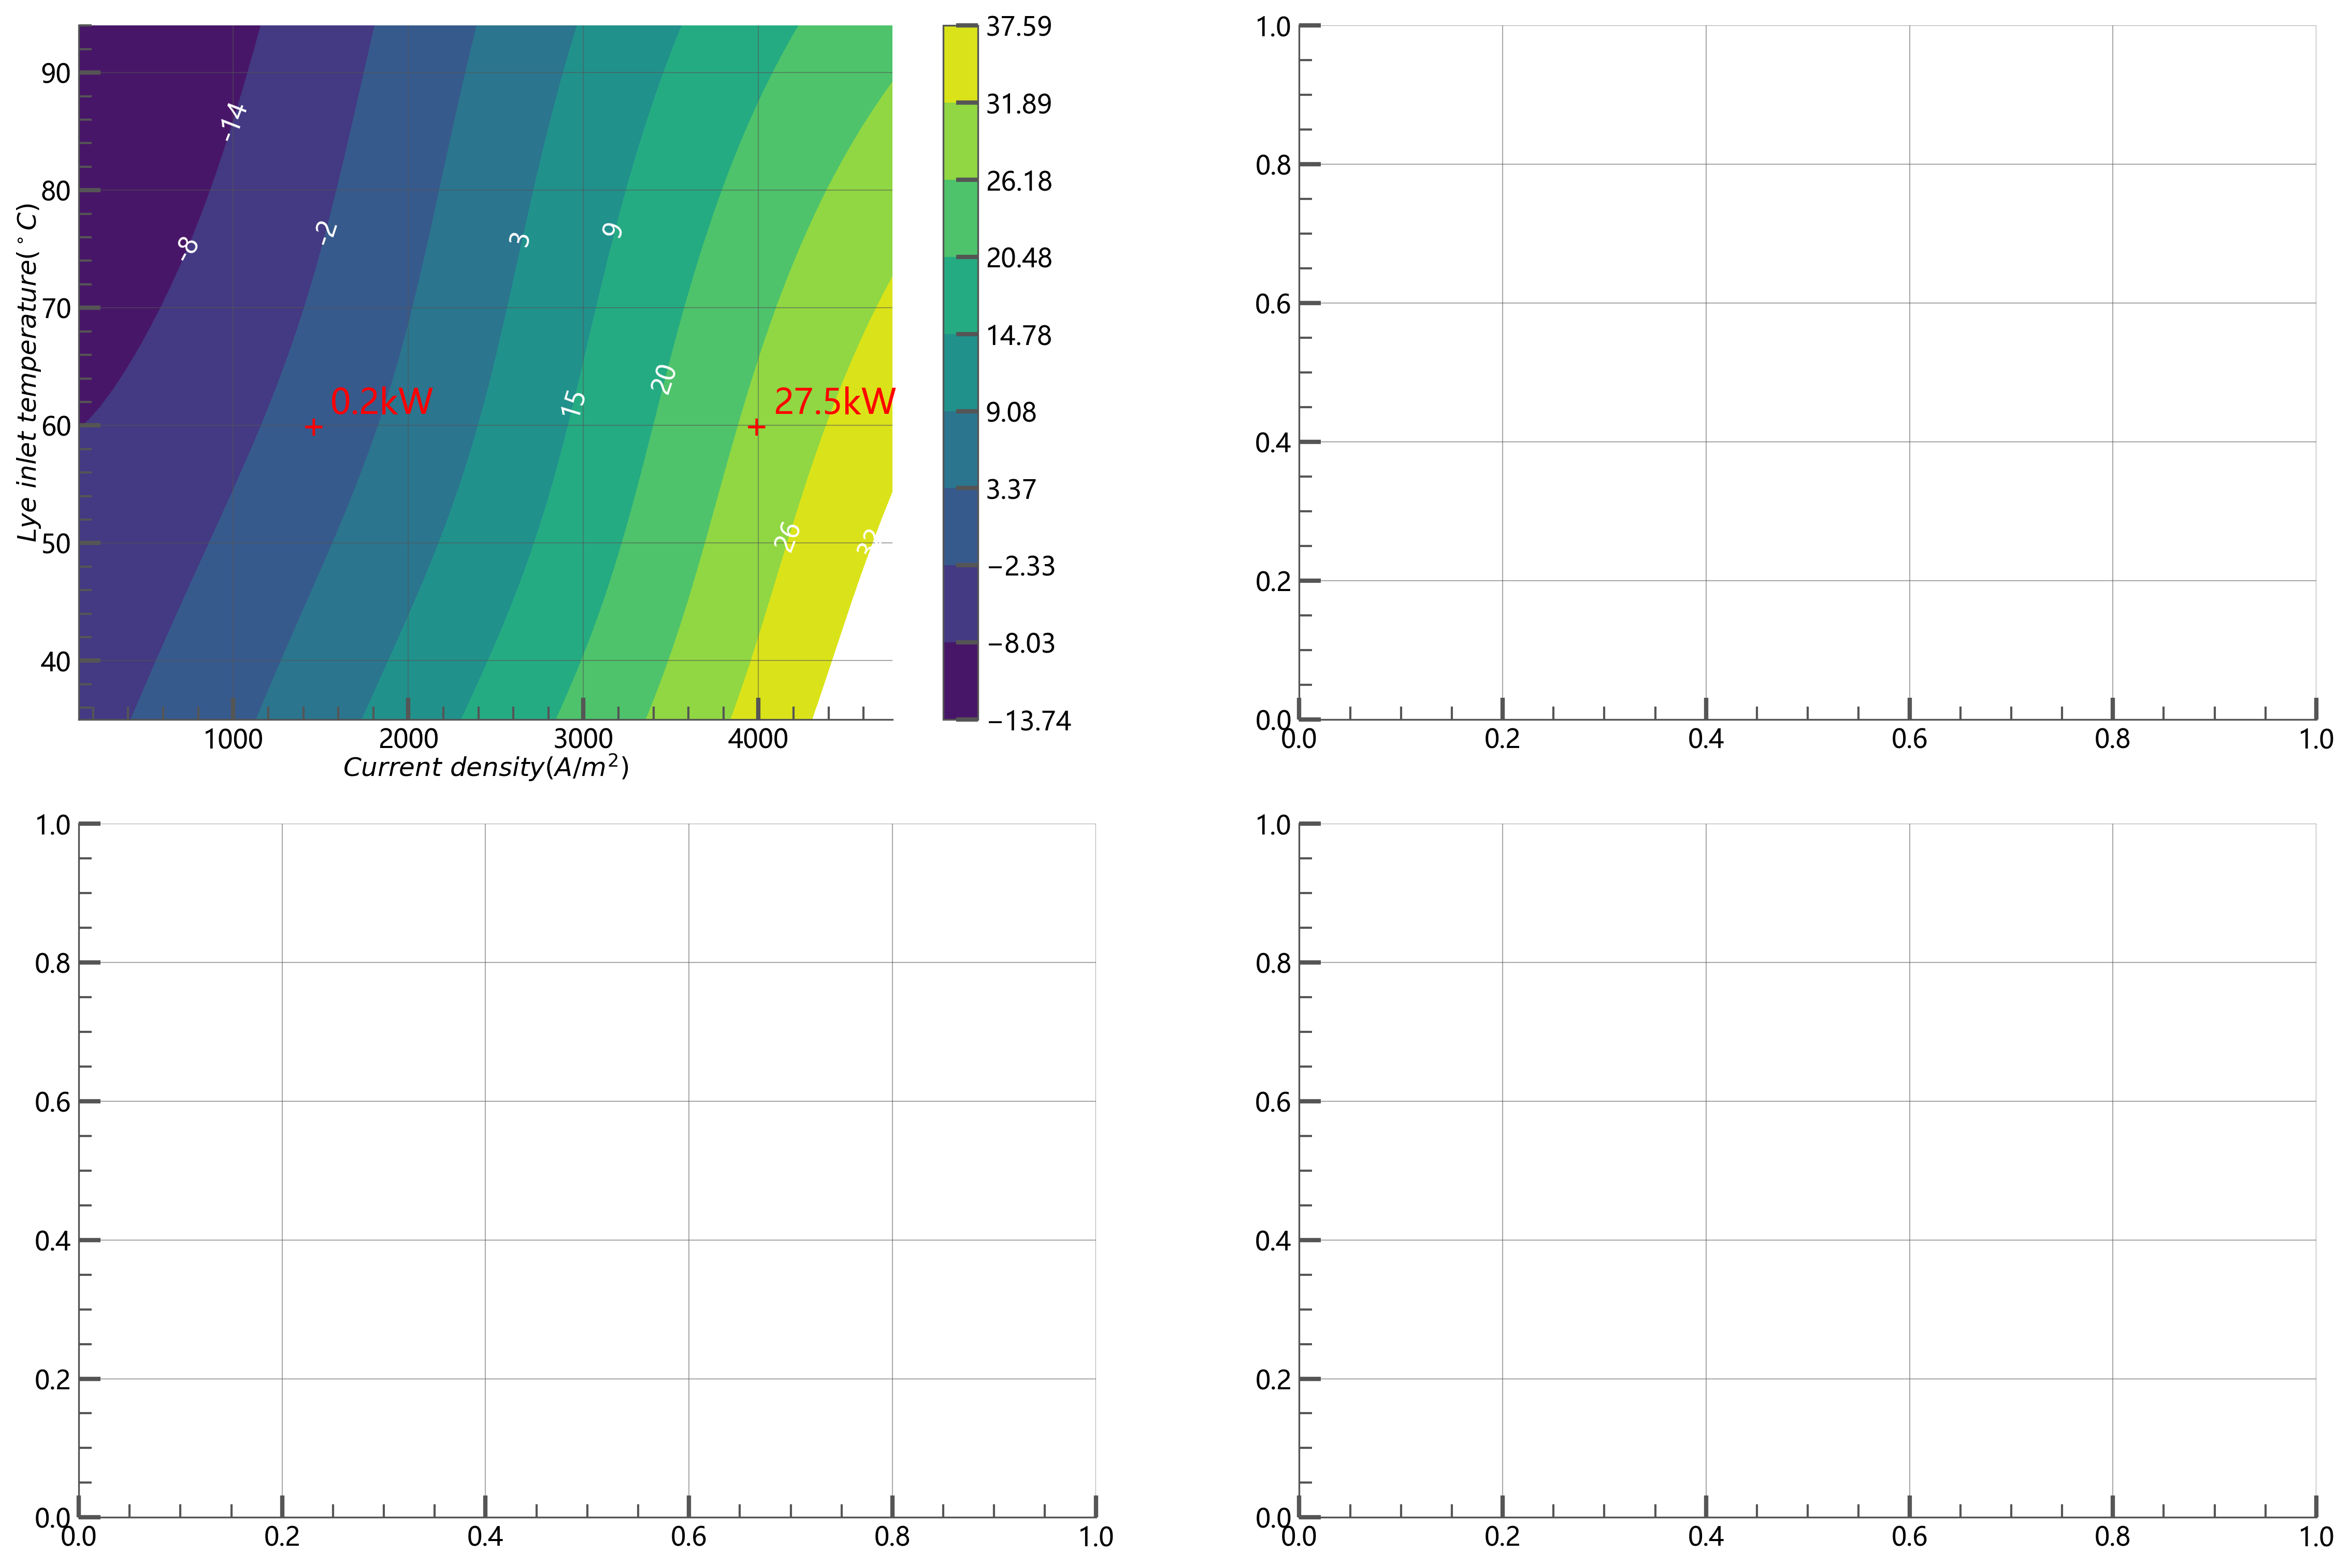

In [3]:
Model_cooling_power_requirement().save()

In [ ]:
cooling_Power_Qlye()

In [ ]:
lye_flow_range = np.arange(0.6,2.1,0.1)
current = OperatingCondition.Optimal.current
lye_temperature = OperatingCondition.Optimal.lye_temperature
temperature_list = []

for lye_flow in lye_flow_range:
    temperature_cur = electrolyzer.temperature_thermal_balance_current(
        ambient_temperature= electrolyzer.default_ambient_temperature,
        lye_flow= lye_flow,
        lye_temperature = lye_temperature,
        current=current
    )
    temperature_list.append(temperature_cur)
plt.plot(
    lye_flow_range,
    temperature_list
)
plt.xlabel(r'$Lye\ flow (m^3/h)$')
plt.ylabel(r'$Outlet temperature (^\circ C)$')

In [ ]:
plt.show()

In [ ]:
(
    current_list,
    voltage_list,
    power_list,
    temperature_list
) = electrolyzer.get_default_polarization()

In [ ]:
electrolyzer.temperature_thermal_balance_current(
    ambient_temperature=15,
    lye_flow=1.5,
    lye_temperature=10,
    current=0
)